In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re


In [ ]:
flight_data = pd.read_csv('flight_data_momondo_All_combined_Cloud_step2.csv') #קריאת הנתונים

# Define airport to city mappings
airport_to_city = {
    'BVA': 'Paris', 'ORY': 'Paris', 'PAR': 'Paris', 'CDG': 'Paris',
    'CIA': 'Rome', 'FCO': 'Rome',
    'SEN': 'London', 'LCY': 'London', 'STN': 'London', 'LHR': 'London', 'LGW': 'London', 'LTN': 'London'
}

# Airports to cities
flight_data['From City'] = flight_data['From Airport'].map(airport_to_city)
flight_data['Landing City'] = flight_data['Landing Airport'].map(airport_to_city)

# Ensuring all data needed for mapping is properly addressed
print(flight_data[['From Airport', 'From City', 'Landing Airport', 'Landing City']].head())
allowed_airports = ['LGW', 'LHR', 'SEN', 'LTN', 'LON', 'STN', 'LCY', 'ORY', 'CDG', 'PAR', 'BVA', 'FCO', 'CIA']

# Filter the DataFrame to keep only rows with allowed airports in the 'From Airport' column
flight_data = flight_data[flight_data['From Airport'].isin(allowed_airports)]

  From Airport From City Landing Airport Landing City
0          LGW    London             ORY        Paris
1          LHR    London             ORY        Paris
2          LGW    London             ORY        Paris
3          LGW    London             ORY        Paris
4          LGW    London             ORY        Paris


C:\Users\liort\AppData\Local\Temp\ipykernel_14988\29360979.py:1: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_data = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv') #קריאת הנתונים


In [ ]:
# Function to convert duration to minutes
def convert_duration_to_minutes(duration):
    hours, minutes = 0, 0
    # Extract hours and minutes using regex
    match = re.match(r'(\d+)h (\d+)m', duration)
    if match:
        hours, minutes = int(match.group(1)), int(match.group(2))
    else:
        match = re.match(r'(\d+)h', duration)
        if match:
            hours = int(match.group(1))
        match = re.match(r'(\d+)m', duration)
        if match:
            minutes = int(match.group(1))
    return hours * 60 + minutes

In [4]:
# Clean the 'Price' column: Remove any non-digit characters and convert to float
flight_data['Price'] = flight_data['Price'].str.extract('(\d+)', expand=False).astype(float)

# Check if there are any null values in the 'Price' column
print(flight_data['Price'].isnull().sum())

1171


In [5]:
# Function to remove outliers for each combination of source and destination city
# Removing outliers using the Tukey (1.5IQR) method 
def remove_outliers(df):
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Appling the function for each city pair
flight_data = flight_data.groupby(['From City', 'Landing City']).apply(remove_outliers).reset_index(drop=True)

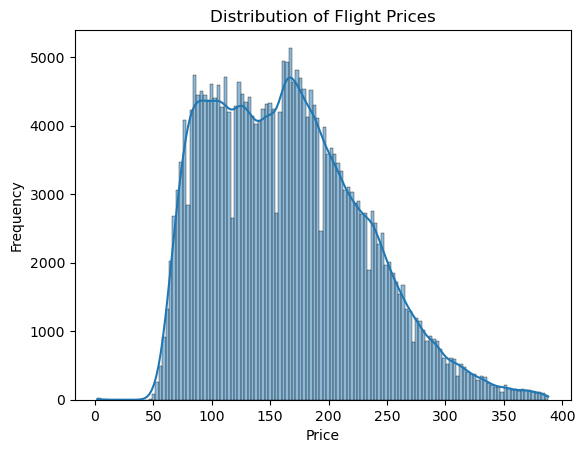

In [ ]:
#1 התפלגות מחירי הטיסות בכללי
sns.histplot(flight_data['Price'], kde=True)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

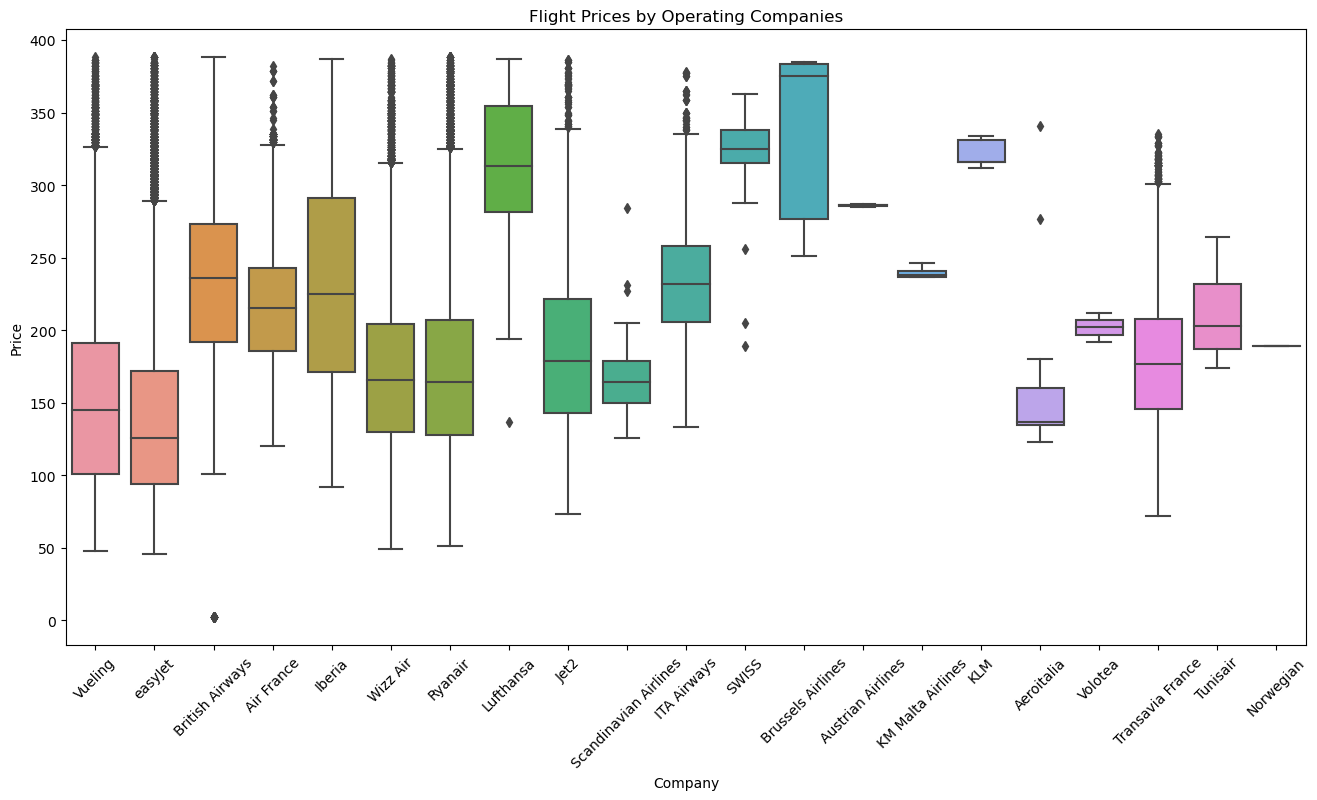

In [7]:
#2 מחירי הטיסות בהינתן חברות מפעילות
plt.figure(figsize=(16, 8))
sns.boxplot(x='Dep Company', y='Price', data=flight_data)
plt.xticks(rotation=45)
plt.title('Flight Prices by Operating Companies')
plt.xlabel('Company')
plt.ylabel('Price')
plt.show()

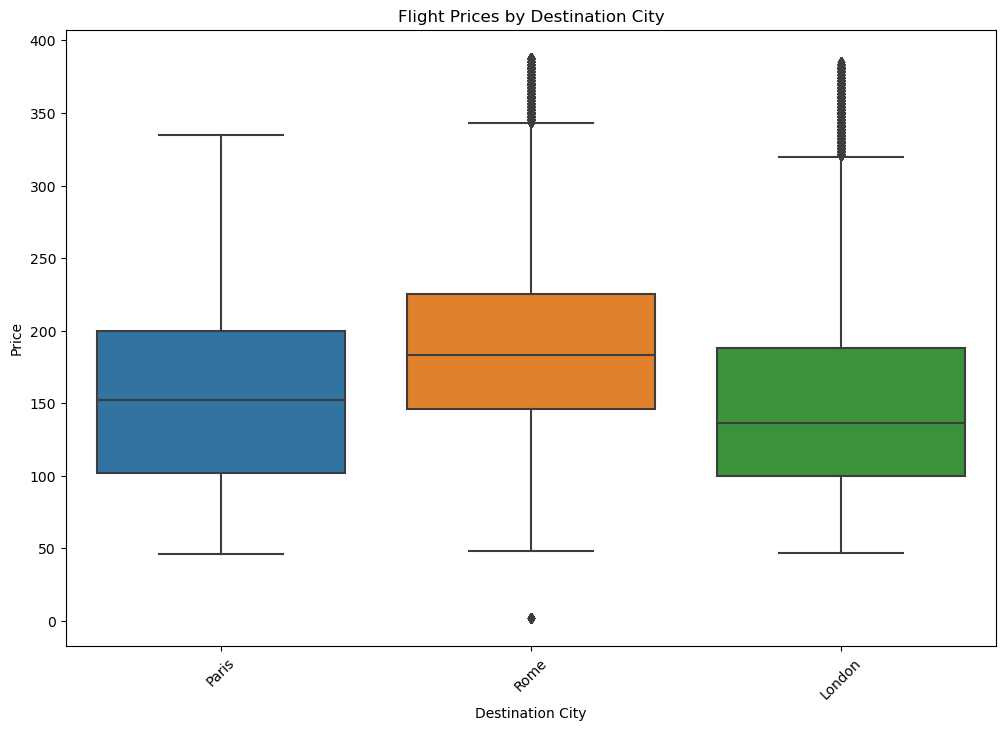

In [8]:
#3.1 מחירי הטיסות על פי יעדים שונים
plt.figure(figsize=(12, 8))
sns.boxplot(x='Landing City', y='Price', data=flight_data)
plt.title('Flight Prices by Destination City')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

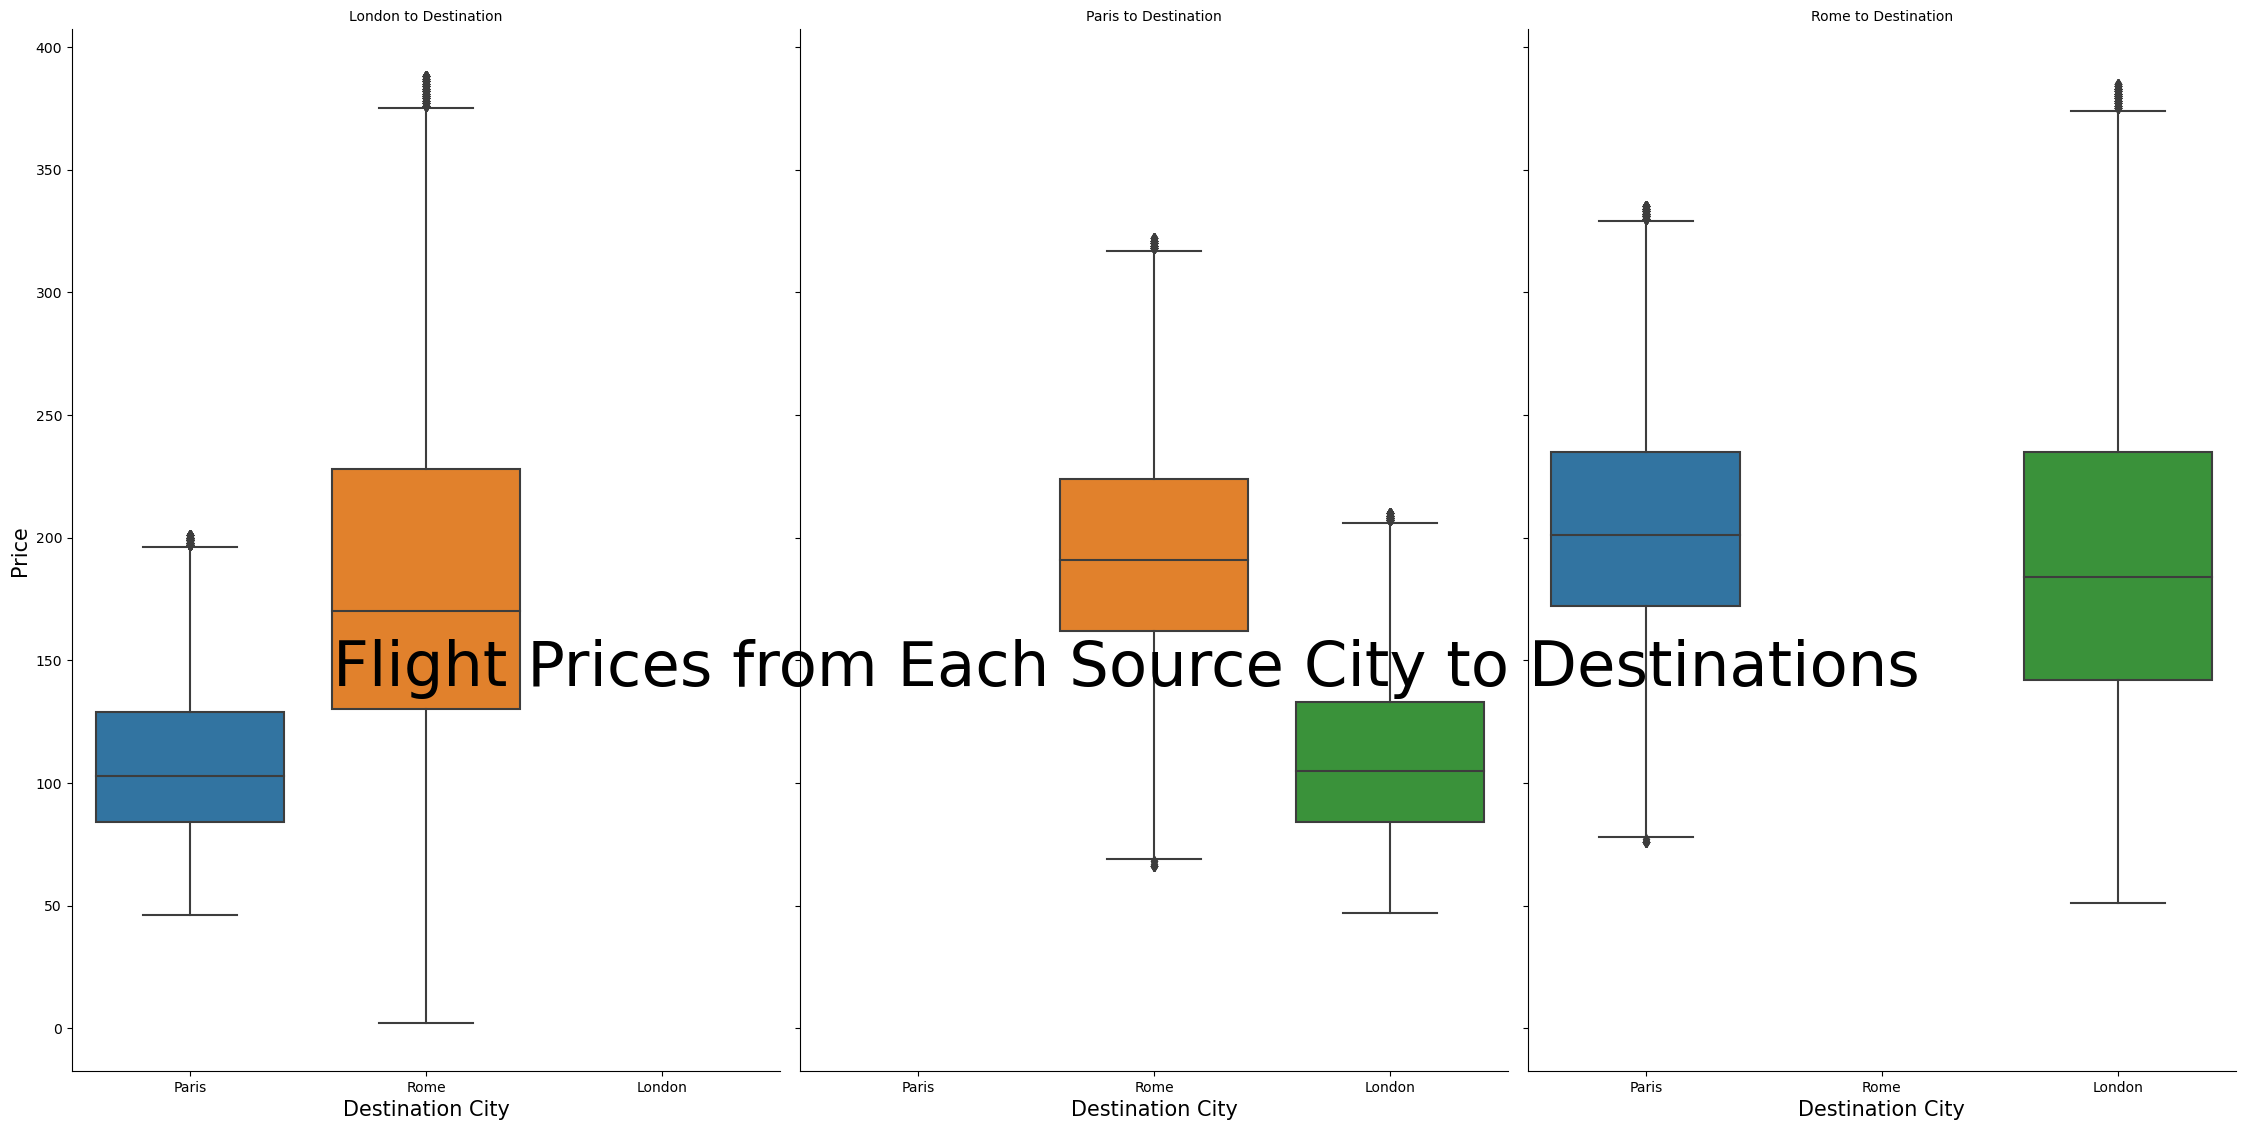

In [9]:
#3.2 מחירי הטיסות על פי יעדים שונים לפי כל מקור!
relevant_data = flight_data[
    (flight_data['From City'].isin(['Paris', 'Rome', 'London'])) & 
    (flight_data['Landing City'].isin(['Paris', 'Rome', 'London']))
]
# Plotting the distribution of flight prices for each route from every source city
g = sns.catplot(
    x='Landing City', 
    y='Price', 
    col='From City', 
    data=relevant_data, 
    kind='box',
    height=5, 
    aspect=1.5,
    col_wrap=3 ,
)
g.set_titles("{col_name} to Destination")
g.set_axis_labels("Destination City", "Price",fontsize=15)
g.set_xticklabels()
plt.subplots_adjust(top=2.2)
g.fig.suptitle('Flight Prices from Each Source City to Destinations',fontsize=45)
plt.show()


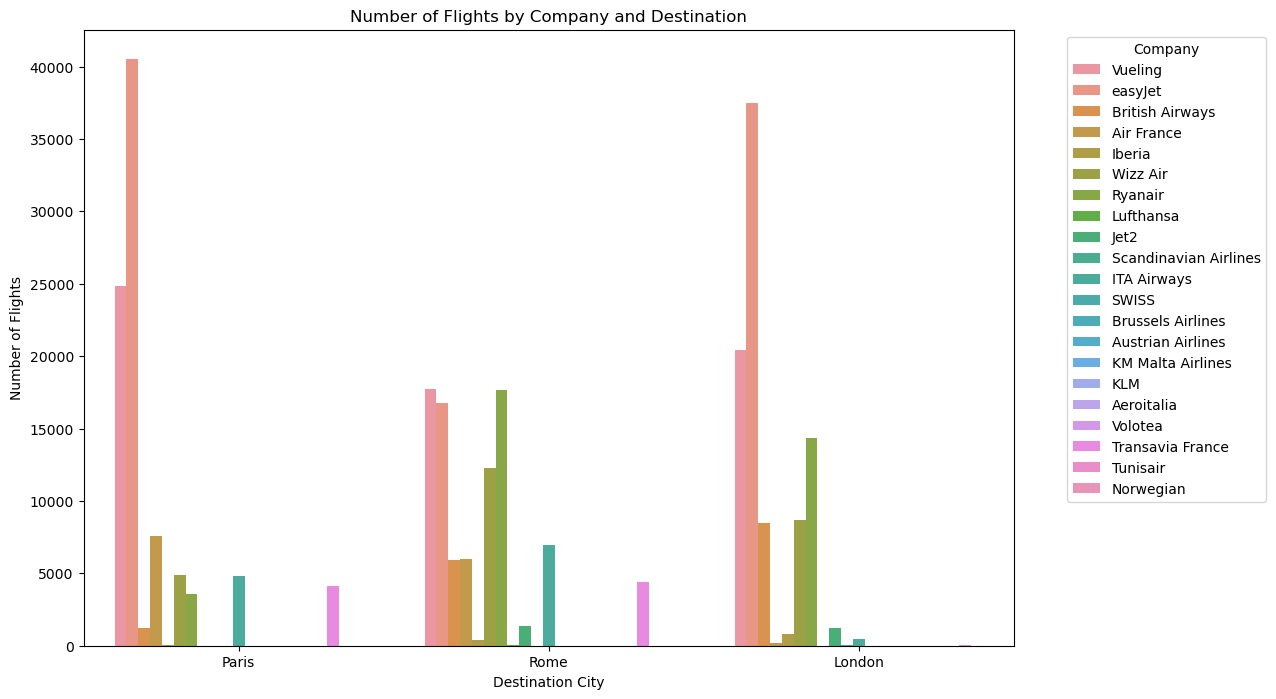

In [10]:
#4 התפלגות הטיסות של חברות השונות על הטיסות פר יעד
plt.figure(figsize=(12, 8))
sns.countplot(x='Landing City', hue='Dep Company', data=flight_data)
plt.title('Number of Flights by Company and Destination')
plt.xlabel('Destination City')
plt.ylabel('Number of Flights')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks()
plt.show()


In [11]:
# Clean and convert 'Stops' to numeric by using our function from earlier but this time on "flight_data".
flight_data['Stops'] = pd.to_numeric(flight_data['Stops'], errors='coerce')

# Filtering flights with 0,1 or 2 stops:
relevant_flights = flight_data[flight_data['Stops'].isin([0, 1, 2])]

# Applying the conversion function we used earlier to the 'Dep Duration' column of relevant_flights
relevant_flights['Dep Duration Minutes'] = relevant_flights['Dep Duration'].apply(lambda x: convert_duration_to_minutes(str(x)))

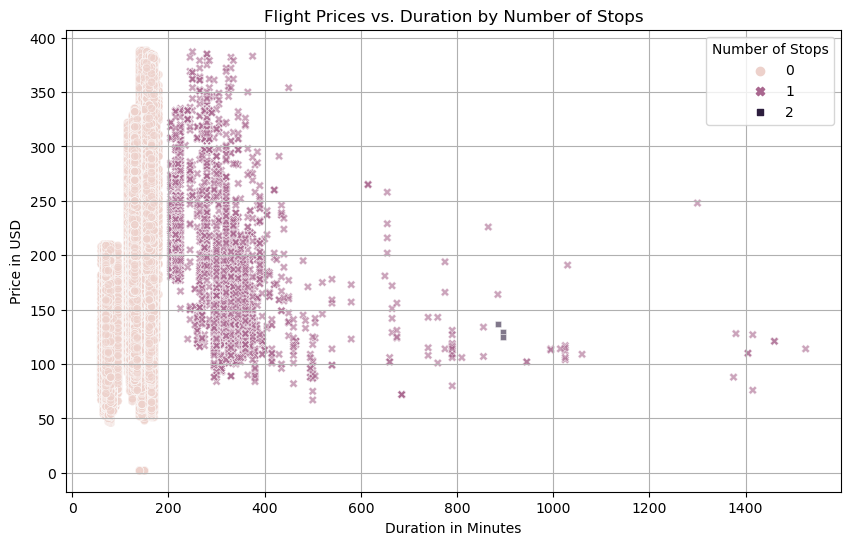

In [12]:
#5 התפלגות זמני קונקשן וזמני טיסות בין היעדים השונים
# 0,זמני קונקשן - 1,2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=relevant_flights, x='Dep Duration Minutes', y='Price', hue='Stops', style='Stops', alpha=0.6)
plt.title('Flight Prices vs. Duration by Number of Stops')
plt.xlabel('Duration in Minutes')
plt.ylabel('Price in USD')
plt.legend(title='Number of Stops')
plt.grid(True)
plt.show()

In [13]:
#מסקנות:
#
# 1.                   נראה שיש קשר בן זמני טיסה ארוכים מהרגיל למחירם המוזל יותר (שכנראה עקב כך)
#
# 2.                                       נראה כי עד ה300 דקות יש התפלגות נורמאלית המזכירה פעמון
#                      כי ככל הנראה- בטווח של עד 5 שעות בטיסות ישירות- ככל שהטיסה לוקחת יותר זמן
#            .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש
print("                                                                                               :מסקנות\n")
print("                        נראה שיש קשר בן זמני טיסה ארוכים מהרגיל למחירם המוזל יותר (שכנראה עקב כך)\n")
print("                                           -נראה כי עד ה300 דקות יש התפלגות נורמאלית המזכירה פעמון")
print("     ..כי לפי הנראה- בטווח של עד 5 שעות ב*טיסות ישירות*- ככל שהטיסה לוקחת יותר זמן היא יותר יקרה")
print("              .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש")
print("כלומר זה לא באמת התפלגות פעמון אם מתייחסים לטיסות ישירות ולטיסות קונקשן בנפרד- אלא עליה לינארית")

                                                                                               :מסקנות

                        נראה שיש קשר בן זמני טיסה ארוכים מהרגיל למחירם המוזל יותר (שכנראה עקב כך)

                                           -נראה כי עד ה300 דקות יש התפלגות נורמאלית המזכירה פעמון
     ..כי לפי הנראה- בטווח של עד 5 שעות ב*טיסות ישירות*- ככל שהטיסה לוקחת יותר זמן היא יותר יקרה
              .כנראה שבגלל שהיעד יותר רחוק ולכן המחיר עולה לפי עלויות טכניות כמו דלק ומשאבי אנוש
כלומר זה לא באמת התפלגות פעמון אם מתייחסים לטיסות ישירות ולטיסות קונקשן בנפרד- אלא עליה לינארית


In [14]:
#ניקוי והכנת הדאטה עבור דרישה 6 - השפעת שדות התעופה בכל עיר על המחירים של הטיסות בין היעדים
flight_data['Dep City'] = flight_data['From Airport'].map(airport_to_city)
flight_data['Landing City'] = flight_data['Landing Airport'].map(airport_to_city)
airport_by_city = {
    'Paris': ['BVA', 'ORY', 'PAR', 'CDG'],
    'Rome':  ['CIA', 'FCO'],
    'London': ['SEN', 'LCR', 'STN', 'LGW', 'LTN', 'LHR']
}

#  Filter rows so that each row’s 'From Airport' is valid for the 'Dep City'
def is_valid_airport(row):
    city = row['Dep City']
    from_airport = row['From Airport']
    # Only keep the row if the from_airport is in the list of valid airports for that city
    if city in airport_by_city:
        return from_airport in airport_by_city[city]
    return False

flight_data['Airport'] = flight_data.apply(is_valid_airport, axis=1)
filtered_data = flight_data[flight_data['Airport']]

c:\Users\liort\anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


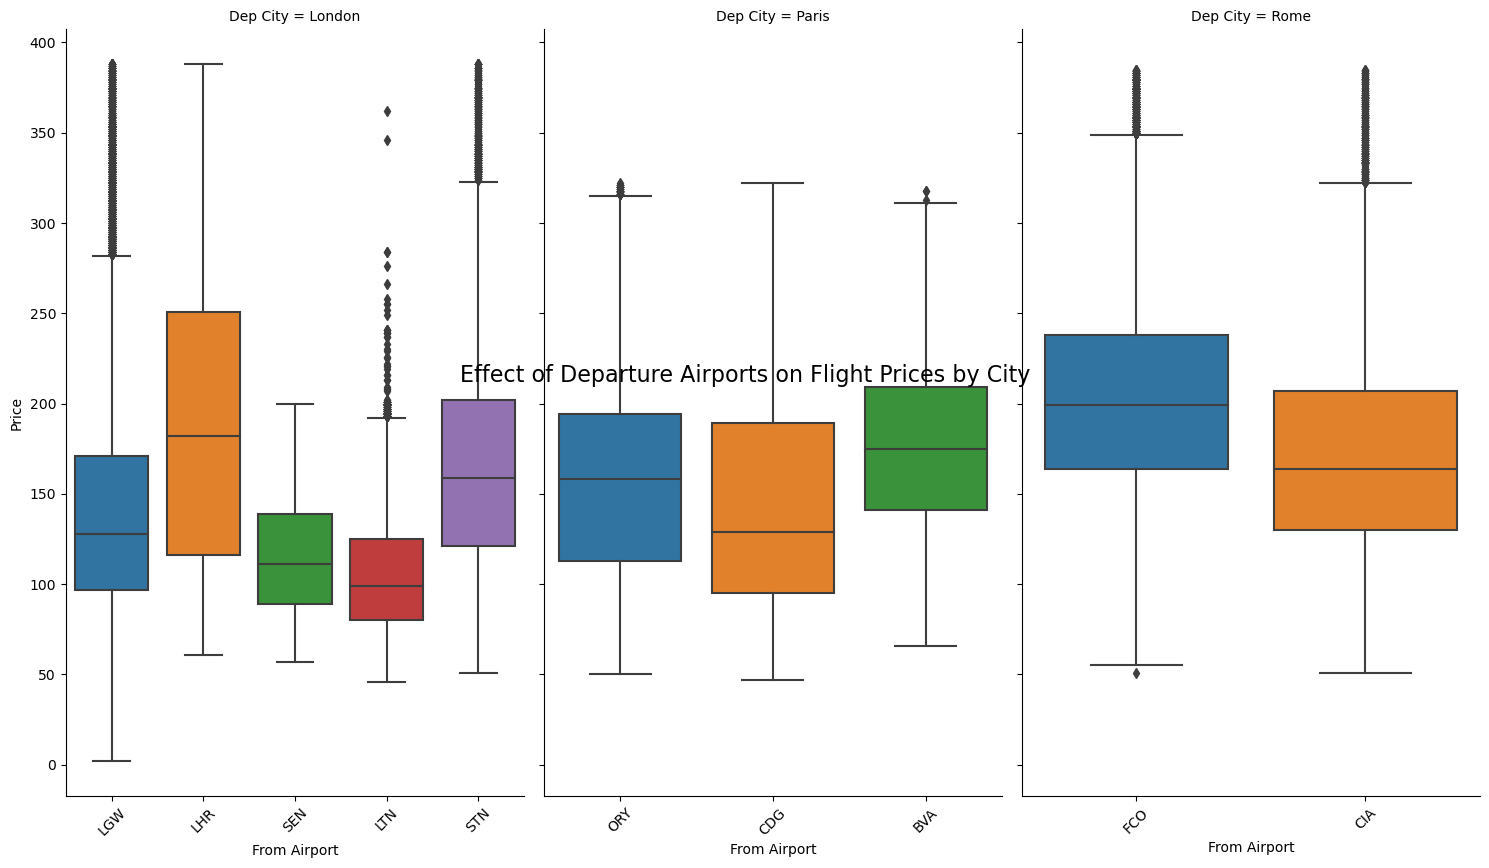

In [15]:
#6 השפעת שדות התעופה בכל עיר על המחירים של הטיסות בין היעדים
g = sns.catplot(
    x='From Airport',
    y='Price',
    col='Dep City',
    data=filtered_data,
    kind='box',
    col_wrap=3,
    height=5,
    aspect=1,
    sharex=False  # ככה שזה יבדיל ויצמיד לכל עיר את השדות תעופה הרלוונטים לו
)

# Rotate labels for readability
g.set_xticklabels(rotation=45)
g.fig.suptitle('Effect of Departure Airports on Flight Prices by City', fontsize=16)
plt.subplots_adjust(top=1.65)  # Move plots down to make space for the title
plt.show()

C:\Users\liort\AppData\Local\Temp\ipykernel_14988\1629745529.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(relevant_flights.corr(), annot=True, cmap='coolwarm', fmt='.2f')


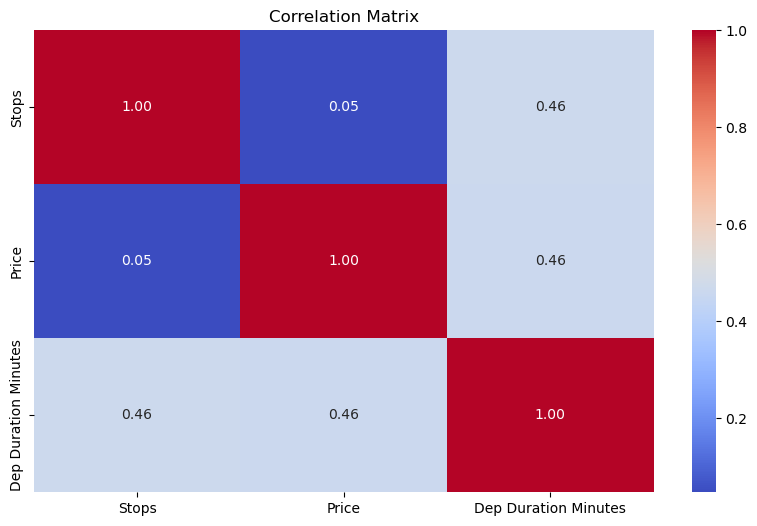

In [16]:
# מטריצת מתאמים בין משתנים מספריים
plt.figure(figsize=(10,6))
sns.heatmap(relevant_flights.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

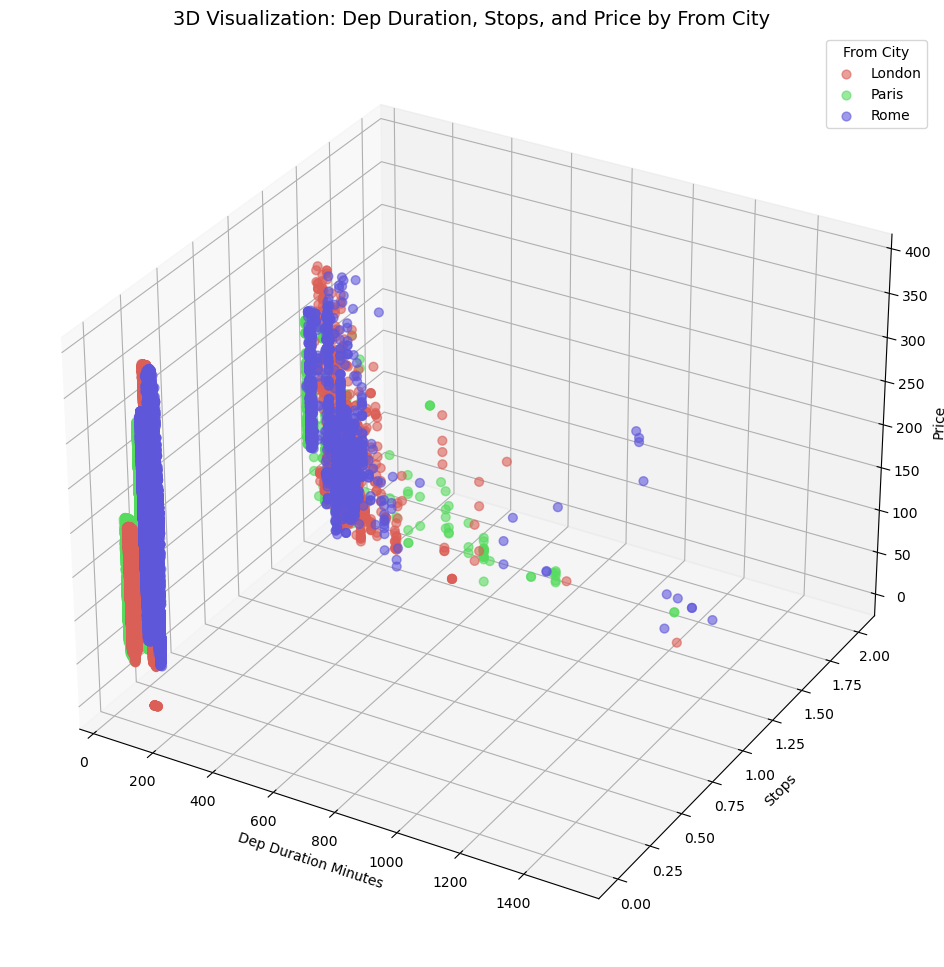

In [98]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# We'll color-code by the departure city
cities = relevant_flights['From City'].unique()
colors = sns.color_palette('hls', len(cities))

# Plot each city in a different color
for city, color in zip(cities, colors):
    subset = relevant_flights[relevant_flights['From City'] == city]
    ax.scatter(subset['Dep Duration Minutes'],subset['Stops'],subset['Price'],color=color,label=city,alpha=0.6,s=40)

# Set axis labels
ax.set_xlabel('Dep Duration Minutes')
ax.set_ylabel('Stops')
ax.set_zlabel('Price')

# Add a legend
ax.legend(title='From City')

# Set a title
plt.title('3D Visualization: Dep Duration, Stops, and Price by From City', fontsize=14)

plt.show()

In [99]:
# שמירת הנתונים לאחר עיבוד
flight_data.to_csv('flight_data_Momondo_Allsnaps_AfterStep2_Clean.csv', index=False)
print(f"flight_data_Momondo_Allsnaps_AfterStep2_Clean.csv")
print(f"Done")

flight_data_Momondo_Allsnaps_AfterStep2_Clean.csv
Done
